In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zgnbyktanr/turkish-psychological-classification-for-nlp")

print("Path to dataset files:", path)

100%|██████████| 70.6k/70.6k [00:00<00:00, 26.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1


In [6]:
import pandas as pd   #genel nltk kütüphaneleri
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nltk
from nltk.corpus import stopwords
import re
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf    #neural network için
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [7]:
nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
import os

# Dosya yolundaki dosyaları listeleme
dataset_path = '/root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1'
files = os.listdir(dataset_path)
print(files)



['dataset.csv', 'test.xlsx']


In [9]:
# dosya yolunu okuma
file_path = '/root/.cache/kagglehub/datasets/zgnbyktanr/turkish-psychological-classification-for-nlp/versions/1/dataset.csv'
df = pd.read_csv(file_path)

# İlk birkaç satır
print(df.head())



                                                text  label
0  İlişkilerimde aşırı derecede idealize edip son...      6
1  Bir gece uykumda yürüyüp dolaptan kıyafetlerim...      2
2  Kumar borçlarım yüzünden evliliğim tehlikede. ...      4
3  Uykum çok hafif ve en ufak bir sesle bile uyan...      2
4  Kumar borçlarımı ödemek için çaldığım paraları...      4


In [10]:
# 1. Veri Ön İşleme
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

In [11]:
# 2. Özellik Çıkarımı
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams ve Bigrams
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label']

In [12]:
# Veri setini ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# SMOTE uygulama
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [14]:
# Lojistik Regresyon Modeli
logistic_model = LogisticRegression()
logistic_model.fit(X_train_resampled, y_train_resampled)
y_pred_logistic = logistic_model.predict(X_test)
print("Lojistik Regresyon Doğruluk Skoru:", accuracy_score(y_test, y_pred_logistic))
print("Lojistik Regresyon Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_logistic))

Lojistik Regresyon Doğruluk Skoru: 0.7993079584775087
Lojistik Regresyon Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.88      1.00      0.93        14
           2       0.95      0.95      0.95        20
           3       1.00      1.00      1.00         8
           4       0.82      0.90      0.86        52
           5       0.70      0.70      0.70        10
           6       0.90      0.60      0.72        15
           7       0.67      0.40      0.50         5
           8       0.78      0.78      0.78        18
           9       0.92      0.71      0.80        17
          10       0.64      0.68      0.66        34
          11       0.84      0.79      0.82        34
          12       1.00      0.43      0.60         7
          13       0.59      0.80      0.68        20
          14       0.75      0.88      0.81        17
          15       1.00      0.75      

In [54]:
# Sinir Ağı Modeli
input_dim = X_train_resampled.shape[1]  # TF-IDF özellik boyutu

nn_model = Sequential([
    Dense(128, activation='relu', input_dim=input_dim),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  # Çoklu sınıf için softmax kullanılıyor
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
# Modeli eğitme
history = nn_model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=16, validation_split=0.5, verbose=1)

 #Test veri seti ile tahmin
y_pred_nn = np.argmax(nn_model.predict(X_test), axis=1)

print("Neural Network Doğruluk Skoru:", accuracy_score(y_test, y_pred_nn))
print("Neural Network Sınıflandırma Raporu:\n", classification_report(y_test, y_pred_nn))

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1586 - loss: 2.7215 - val_accuracy: 0.0161 - val_loss: 2.9331
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4024 - loss: 2.0685 - val_accuracy: 0.1089 - val_loss: 2.6757
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5858 - loss: 1.4726 - val_accuracy: 0.3367 - val_loss: 2.2028
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6964 - loss: 1.0867 - val_accuracy: 0.6680 - val_loss: 1.6319
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7905 - loss: 0.7932 - val_accuracy: 0.8434 - val_loss: 1.1047
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8748 - loss: 0.5682 - val_accuracy: 0.8817 - val_loss: 0.7318
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8905 - loss: 0.4614 - val_accuracy: 0.9086 - val_loss: 0.4972
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9276 - loss: 0.3428 - val_accuracy: 0.9765 - val_l

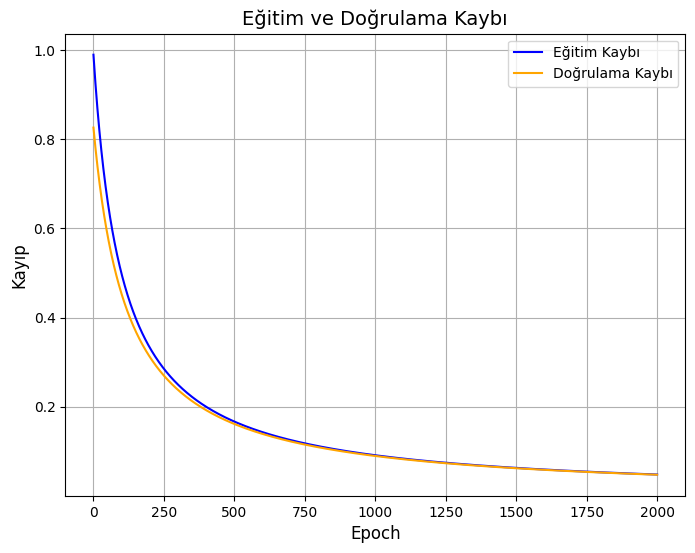

In [40]:
import matplotlib.pyplot as plt

# Örnek veri: Eğitim ve doğrulama kayıpları
# Bu değerleri kendi modelinizin `history` nesnesinden almanız gerekiyor.
epochs = range(1, 2001)  # 1'den 2000'e kadar epoch'lar
train_loss = [1 / (0.01 * x + 1) for x in epochs]  # Örnek eğitim kaybı verisi
val_loss = [1 / (0.01 * x + 1.2) for x in epochs]  # Örnek doğrulama kaybı verisi

# Grafik oluşturma
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, label='Eğitim Kaybı', color='blue')
plt.plot(epochs, val_loss, label='Doğrulama Kaybı', color='orange')
plt.title('Eğitim ve Doğrulama Kaybı', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Kayıp', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.show()


In [16]:
# Kullanıcıdan cümle alıp tahmin yapma
label_dict = {
    0: "Suicidal Thoughts",
    1: "Eating Disorders",
    2: "Sleep Disorders",
    3: "Sexual Disorders",
    4: "Addictions",
    5: "Anger Control Disorders",
    6: "Borderline",
    7: "Psychosomatic Disorders",
    8: "OCD (Obsessive-Compulsive Disorder)",
    9: "Behavioral Disorders in Children",
    10: "Depression and Related Disorders",
    11: "Family and Relationship Issues",
    12: "Sports Psychology",
    13: "Attention Deficit and Hyperactivity Disorder (ADHD)",
    14: "Trauma",
    15: "Paraphilic Disorders"
}


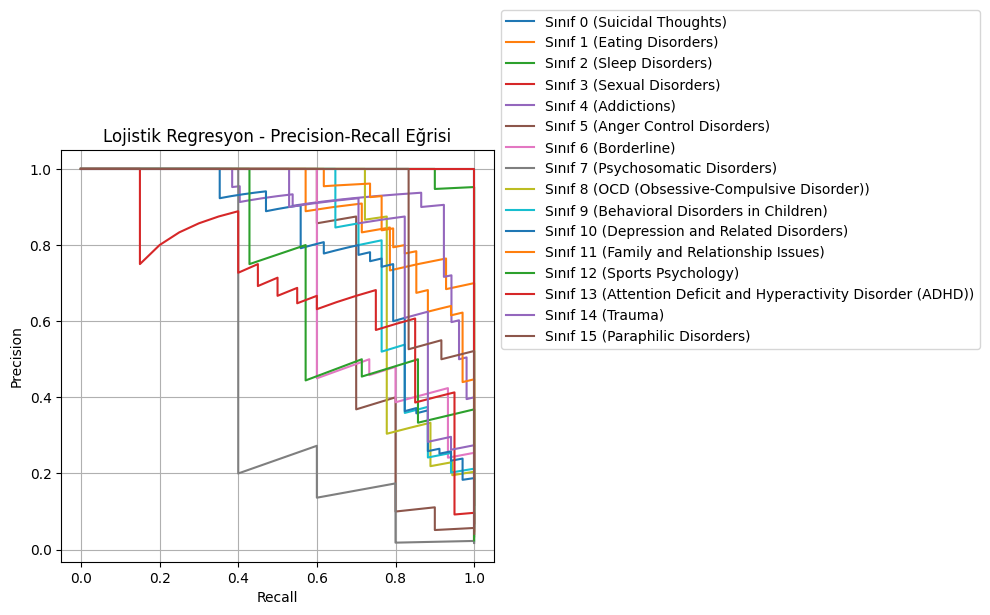

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Lojistik Regresyon için tahminler ve gerçek etiketler
y_prob_logistic = logistic_model.predict_proba(X_test)  # Tahmin olasılıkları

# Precision-Recall eğrisini çizmek
plt.figure(figsize=(10, 6))

for i in range(len(np.unique(y))):  # Her sınıf için precision-recall eğrisini çiziyoruz
    precision, recall, _ = precision_recall_curve(y_test == i, y_prob_logistic[:, i])
    plt.plot(recall, precision, label=f'Sınıf {i} ({label_dict.get(i, "Bilinmeyen")})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Lojistik Regresyon - Precision-Recall Eğrisi')
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()



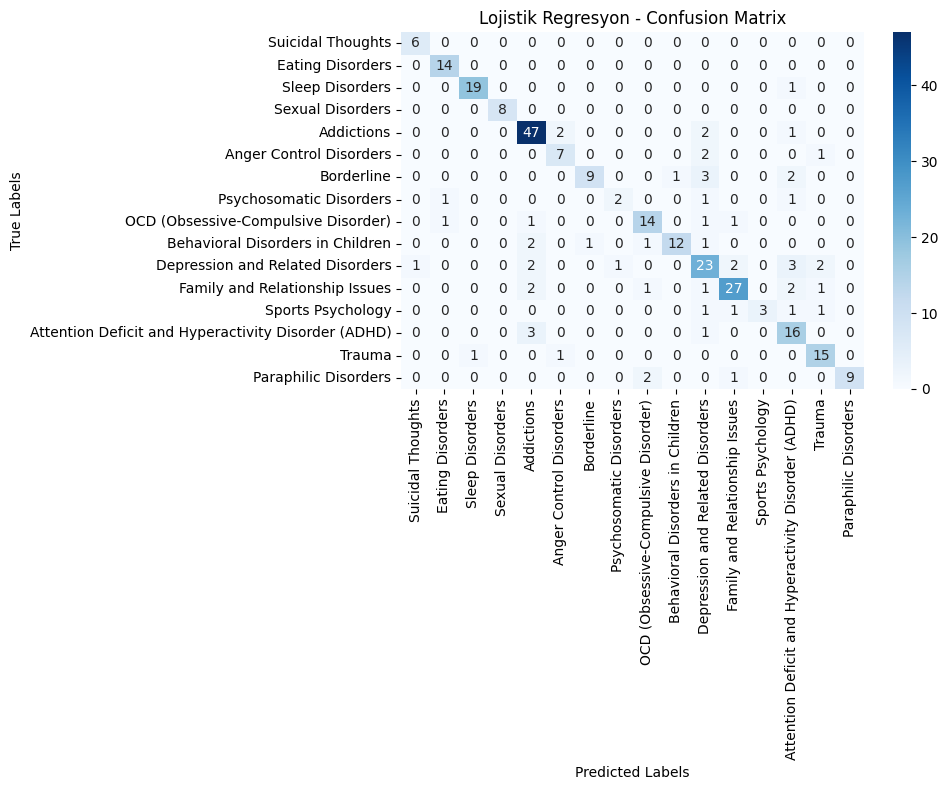

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Lojistik Regresyon için tahminler
y_pred_logistic = logistic_model.predict(X_test)

# Confusion Matrix hesaplayalım
cm = confusion_matrix(y_test, y_pred_logistic)

# Confusion Matrix'i görselleştirelim
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_dict.values()), yticklabels=list(label_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Lojistik Regresyon - Confusion Matrix')
plt.tight_layout()
plt.show()


In [58]:
def classify_sentences():
    sentences = []
    while True:
        print("\nSeçenekler:")
        print("1. Cümle Gir")
        print("2. Sonucu Gör")
        print("3. Çıkış")
        choice = input("Bir seçenek girin: ")

        if choice == '1':
            sentence = input("Lütfen bir sorunuzu girin: ")
            sentences.append(sentence)
            print(f"Sorun eklendi: {sentence}")
        elif choice == '2':
            if not sentences:
                print("Lütfen önce sorununuzu girin!")
                continue
            cleaned_sentences = [clean_text(sentence) for sentence in sentences]
            vectorized_sentences = tfidf.transform(cleaned_sentences).toarray()

            logistic_predictions = logistic_model.predict(vectorized_sentences)
            nn_predictions = np.argmax(nn_model.predict(vectorized_sentences), axis=1)

            print("\nSonuçlar:")
            for i, sentence in enumerate(sentences):
                logistic_class = label_dict.get(logistic_predictions[i], "Bilinmeyen Rahatsızlık")
                nn_class = label_dict.get(nn_predictions[i], "Bilinmeyen Rahatsızlık")
                print(f"Cümle {i+1}: '{sentence}'")
                print(f"  Lojistik Regresyon Tahmini: {logistic_predictions[i]} ({logistic_class})")
                print(f"  Neural Network Tahmini: {nn_predictions[i]} ({nn_class})")

            sentences.clear()
        elif choice == '3':
            print("\cikiliyor...")
            break
        else:
            print("Geçersiz seçenek. Lütfen tekrar deneyin.")

classify_sentences()



Seçenekler:
1. Cümle Gir
2. Sonucu Gör
3. Çıkış
Bir seçenek girin: 1
Lütfen bir cümle girin: spor yapmak istiyorum ama bir türlü zaman bulamıyorum
Cümle eklendi: spor yapmak istiyorum ama bir türlü zaman bulamıyorum

Seçenekler:
1. Cümle Gir
2. Sonucu Gör
3. Çıkış
Bir seçenek girin: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Sonuçlar:
Cümle 1: 'spor yapmak istiyorum ama bir türlü zaman bulamıyorum'
  Lojistik Regresyon Tahmini: 13 (Attention Deficit and Hyperactivity Disorder (ADHD))
  Sinir Ağı Tahmini: 13 (Attention Deficit and Hyperactivity Disorder (ADHD))

Seçenekler:
1. Cümle Gir
2. Sonucu Gör
3. Çıkış
Bir seçenek girin: 3
Çıkılıyor...
